In [0]:
import os, glob, shutil
from pathlib import Path
from time import sleep

import torch
from torchvision import transforms as T
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from PIL import Image

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

downloaded data successfully


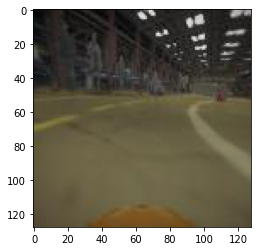

In [4]:
if not Path("./data/train/warehouse_time_step_0.jpg").is_file():
  
  # Download files
  os.system("wget 'https://www.dropbox.com/s/08vgl5wdage8nw0/data_v1.zip?dl=0' -O data.zip")
  os.system("unzip -q data.zip")
  sleep(120)
  print('downloaded data successfully')

  # Remove unnecessary files
  os.listdir('./').remove('data.zip')

  image_dir = './data_v1/'
  file_names = os.listdir(image_dir)

  # Split on train and val parts
  TRAIN_SIZE = 0.7

  parts = ['train', 'val']

  train_file_names = file_names[:int(len(file_names) * TRAIN_SIZE)]
  val_file_names = file_names[int(len(file_names) * TRAIN_SIZE):]

  # Move to corresponding folder
  for part, files in zip(parts, [train_file_names, val_file_names]):
    new_part = os.path.join(image_dir, part)
    if not os.path.exists(new_part):
      os.makedirs(new_part)
    for f in files:
      shutil.move(os.path.join(image_dir, f), new_part)

  # Show sample
  img = mpimg.imread(image_dir + parts[1] + '/' + os.listdir(new_part)[1])
  plt.imshow(img)
  plt.show()

In [0]:
class WareHouseDataset(Dataset):
    def __init__(self, image_path,  image_transform=None):
        super(WareHouseDataset, self).__init__()

        images = glob.glob(os.path.join(image_path, '*.jpg'))
        images.sort()

        self.data = list(images)
        self.image_transform = image_transform

    def __getitem__(self, idx):
        
        image_path = self.data[idx]        
        image= Image.open(image_path)
        image = self.image_transform(image)
        #print(image)
        return image 

    def __len__(self):
        return len(self.data)

In [0]:
image_transforms = {
    'train': T.ToTensor(),
    'val'  : T.ToTensor()
    }
    
datasets = {part: WareHouseDataset(os.path.join(image_dir, part), 
                                   image_transform=image_transforms[part])
            for part in parts
            }

In [0]:
batch_sizes = {'train': 32, 'val': 64}
drop_shuffle = {'train': True, 'val': False}

dataloaders = {part: torch.utils.data.DataLoader(datasets[part],
                                                  batch_size=batch_sizes[part],
                                                  shuffle=drop_shuffle[part],
                                                  num_workers=32,
                                                  drop_last=drop_shuffle[part])
               for part in parts}

In [8]:
dataloaders

{'train': <torch.utils.data.dataloader.DataLoader at 0x7f6c1a286cc0>,
 'val': <torch.utils.data.dataloader.DataLoader at 0x7f6c1a286128>}

In [0]:
import time, random
import numpy as np
from PIL import Image
from scipy import stats
from imageio import imsave
import matplotlib.pyplot as plt
from itertools import permutations
from skimage.util.shape import view_as_blocks

from torchvision import datasets

In [0]:
def shuffle(im, num, rotate= False):
  
  im = im.permute(1,2,0).numpy()

  map = {}
  rows=cols=num
  blk_size=im.shape[0]//rows
   
  img_blks=view_as_blocks(im, block_shape=(blk_size, blk_size,3)).reshape((-1, blk_size, blk_size, 3))
  img_shuff=np.zeros((im.shape[0],im.shape[1],3))
   
  a=np.arange(rows*rows, dtype=np.uint8)
  b=np.random.permutation(a)
  
  map = {k:v for k,v in zip(a,b)}
  #print ("Key Map:-\n" + str(map))
  
  for i in range(0,rows):
    for j in range(0,cols):
     x,y = i*blk_size, j*blk_size

     if rotate:
      rot_val=random.randrange(0,4)
      img_shuff[x:x+blk_size, y:y+blk_size] = np.rot90(img_blks[map[i*rows + j]], rot_val)
      
     else:
      img_shuff[x:x+blk_size, y:y+blk_size] = img_blks[map[i*rows + j]]

  img_shuff = torch.FloatTensor(img_shuff).permute(0,1,2)

  return img_shuff

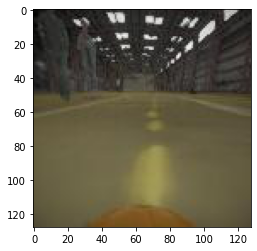

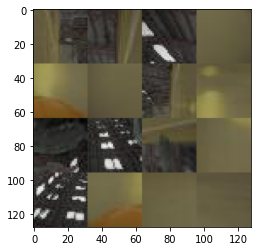

In [11]:
im = next(iter(dataloaders['train']))[0]
shuff=shuffle(im, 4, rotate= True)
# Show sample
plt.imshow(im.permute(1,2,0))
plt.show()
plt.imshow(shuff)
plt.show()

In [0]:
from torch import nn

In [0]:
class VAE(nn.Module):
    def __init__(self, image_size, channel_num, kernel_num, z_size):
        # configurations
        super().__init__()
        self.image_size = image_size
        self.channel_num = channel_num
        self.kernel_num = kernel_num
        self.z_size = z_size

        # encoder
        self.encoder = nn.Sequential(
            self._conv(channel_num, kernel_num // 4),
            self._conv(kernel_num // 4, kernel_num // 2),
            self._conv(kernel_num // 2, kernel_num, last=True),
        )

        # encoded feature's size and volume
        self.feature_size = image_size // 8
        self.feature_volume = kernel_num * (self.feature_size ** 2)

        # q
        self.q_mean = self._linear(self.feature_volume, z_size, relu=False)
        self.q_logvar = self._linear(self.feature_volume, z_size, relu=False)

        # projection
        self.project = self._linear(z_size, self.feature_volume, relu=False)

        # decoder
        self.decoder = nn.Sequential(
            self._deconv(kernel_num, kernel_num // 2),
            self._deconv(kernel_num // 2, kernel_num // 4),
            self._deconv(kernel_num // 4, channel_num, last=True),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = x.cpu().detach()
        for i, _ in enumerate(x):
          x[i] = shuffle(x[i], 4, rotate= True).permute(2,0,1)
        x = x.cuda()

        # encode x
        encoded = self.encoder(x)

        # sample latent code z from q given x.
        mean, logvar = self.q(encoded)
        z = self.z(mean, logvar)
        z_projected = self.project(z).view(
            -1, self.kernel_num,
            self.feature_size,
            self.feature_size,
        )

        # reconstruct x from z
        x_reconstructed = self.decoder(z_projected)

        # return the parameters of distribution of q given x and the
        # reconstructed image.
        return (mean, logvar), x_reconstructed

    # ==============
    # VAE components
    # ==============

    def q(self, encoded):
        unrolled = encoded.view(-1, self.feature_volume)
        return self.q_mean(unrolled), self.q_logvar(unrolled)

    def z(self, mean, logvar):
        std = logvar.mul(0.5).exp_()
        eps = (
            Variable(torch.randn(std.size())).cuda() if self._is_on_cuda else
            Variable(torch.randn(std.size()))
        )
        return eps.mul(std).add_(mean)

    def reconstruction_loss(self, x_reconstructed, x):
        return nn.BCELoss(size_average=False)(x_reconstructed, x) / x.size(0)

    def kl_divergence_loss(self, mean, logvar):
        return ((mean**2 + logvar.exp() - 1 - logvar) / 2).sum() / mean.size(0)

    # =====
    # Utils
    # =====

    @property
    def name(self):
        return (
            'VAE'
            '-{kernel_num}k'
            '-{channel_num}x{image_size}x{image_size}'
        ).format(
            kernel_num=self.kernel_num,
            image_size=self.image_size,
            channel_num=self.channel_num,
        )

    def sample(self, size):
        z = Variable(
            torch.randn(size, self.z_size).cuda() if self._is_on_cuda() else
            torch.randn(size, self.z_size)
        )
        z_projected = self.project(z).view(
            -1, self.kernel_num,
            self.feature_size,
            self.feature_size,
        )
        return self.decoder(z_projected).data

    def _is_on_cuda(self):
        return next(self.parameters()).is_cuda

    # ======
    # Layers
    # ======

    def _conv(self, channel_size, kernel_num, last=False):
        conv = nn.Conv2d(
                channel_size, kernel_num,
                kernel_size=3, stride=2, padding=1,
        )
        return conv if last else nn.Sequential(
            conv,
            nn.BatchNorm2d(kernel_num),
            nn.ReLU(),
        )

    def _deconv(self, channel_num, kernel_num, last=False):
        deconv = nn.ConvTranspose2d(
            channel_num, kernel_num,
            kernel_size=4, stride=2, padding=1,
        )
        return deconv if last else nn.Sequential(
            deconv,
            nn.BatchNorm2d(kernel_num),
            nn.ReLU(),
        )

    def _linear(self, in_size, out_size, relu=True):
        return nn.Sequential(
            nn.Linear(in_size, out_size),
            nn.ReLU(),
        ) if relu else nn.Linear(in_size, out_size)
        

In [14]:
!pip install livelossplot

In [0]:
from torch import optim
from torch.autograd import Variable
from tqdm import tqdm
from livelossplot import PlotLosses
import copy

In [0]:
model = VAE(
        image_size=128,
        channel_num=3,
        kernel_num=128,
        z_size=128,
    ).cuda()
optimizer = optim.Adam(model.parameters(), 
                       #lr=lr,
                       #weight_decay=weight_decay,
)

In [0]:
def train_model(model, optimizer, epochs):
  min_val_loss = np.inf
  liveloss = PlotLosses()
  for epoch in range(epochs):
    logs = {}
    #train
    model.train()
    losses = list()
    for input in dataloaders['train']:
      input = input.cuda()

      optimizer.zero_grad()
      (mean, logvar), x_reconstructed = model(input)

      reconstruction_loss = model.reconstruction_loss(x_reconstructed, input)
      kl_divergence_loss = model.kl_divergence_loss(mean, logvar)
      total_loss = reconstruction_loss + kl_divergence_loss

      # backprop gradients from the loss
      total_loss.backward()
      optimizer.step()

      losses.append(total_loss.detach().cpu().numpy())

    prefix = ''
    logs[prefix + 'loss'] = np.mean(losses)

    # val
    model.eval()
    losses = list()
    for input in dataloaders['val']:

      input = input.cuda()

      (mean, logvar), x_reconstructed = model(input)

      reconstruction_loss = model.reconstruction_loss(x_reconstructed, input)
      kl_divergence_loss = model.kl_divergence_loss(mean, logvar)
      total_loss = reconstruction_loss + kl_divergence_loss


      losses.append(total_loss.detach().cpu().numpy())

    prefix = 'val_'
    logs[prefix + 'loss'] = np.mean(losses)

    liveloss.update(logs)
    liveloss.send()

    if np.mean(losses) <= min_val_loss:
      min_val_loss = np.mean(losses)
      best_model = copy.deepcopy(model.state_dict())
      torch.save(model.state_dict(), 'best_model.pth.tar')


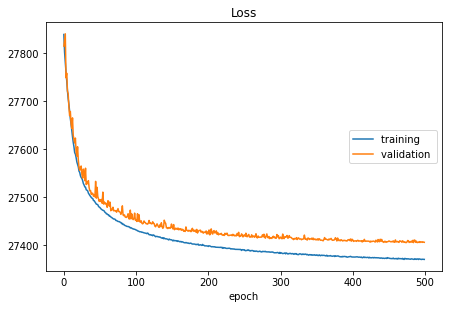

Loss
	training         	 (min: 27370.703, max: 27838.982, cur: 27370.955)
	validation       	 (min: 27405.859, max: 27840.434, cur: 27406.537)


In [22]:
train_model(model, optimizer, 500)